## LGBM & XGBM

#### Objective:
The objective of this assignment is to compare the performance of Light GBM and XG Boost algorithms using the Titanic dataset. 


In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, classification_report, confusion_matrix, roc_curve, auc)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
import lightgbm as lgb
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

#### Exploratory Data Analysis (EDA):
1.	Load the Titanic dataset using Python's pandas library.


In [102]:
df = pd.read_csv('diabetes.csv')
df.shape

(768, 9)

In [103]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [104]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


##### 2.	Check for missing values.

In [105]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [106]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


##### 3.	Explore data distributions using histograms and box plots.

Text(0.5, 0, 'Age')

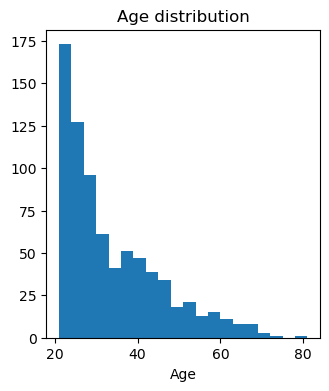

In [107]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(df['Age'].dropna(), bins=20)
plt.title('Age distribution')
plt.xlabel('Age')

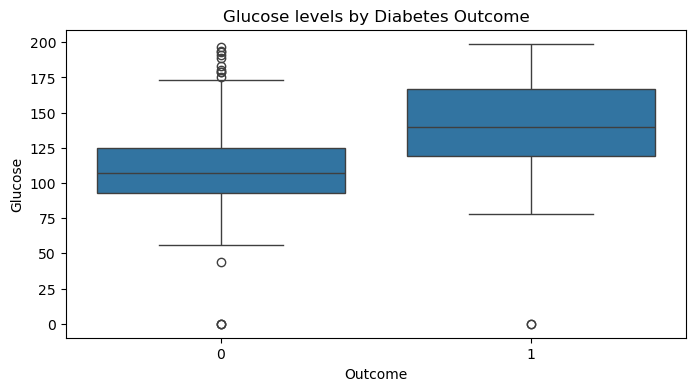

In [108]:
plt.figure(figsize=(8,4))
sns.boxplot(x='Outcome', y='Glucose', data=df)
plt.title('Glucose levels by Diabetes Outcome')
plt.show()

##### 4.	Visualize relationships between features and survival using scatter plots and bar plots.

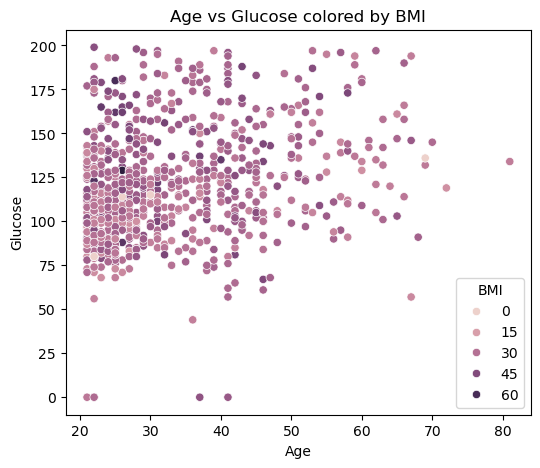

In [109]:
plt.figure(figsize=(6,5))
sns.scatterplot(x='Age', y='Glucose', hue='BMI', data=df)
plt.title('Age vs Glucose colored by BMI')
plt.show()

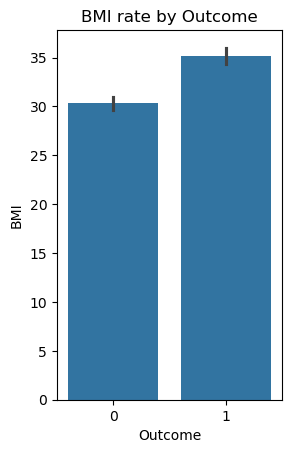

In [110]:
plt.subplot(1,2,2)
sns.barplot(x='Outcome', y='BMI', data=df)
plt.title('BMI rate by Outcome')
plt.show()

#### Data Preprocessing:
1.	Impute missing values.
2.	Encode categorical variables using one-hot encoding or label encoding. 
3.	If needed you can apply more preprocessing methods on the given dataset.


In [111]:
target_col = 'Outcome'
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

In [112]:
numeric_features = X.select_dtypes(include=np.number).columns.tolist()

numeric_features

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [113]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
numeric_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [114]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features)
])
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Pregnancies', 'Glucose', 'BloodPressure',
                                  'SkinThickness', 'Insulin', 'BMI',
                                  'DiabetesPedigreeFunction', 'Age'])])

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

#### Building Predictive Models:
1.	Split the preprocessed dataset into training and testing sets.
2.	Choose appropriate evaluation metrics (e.g., accuracy, precision, recall, F1-score) for model evaluation.
3.	Build predictive models using LightGBM and XGBoost algorithms.
4.	Train the models on the training set and evaluate their performance on the testing set.
5.	Use techniques like cross-validation and hyperparameter tuning to optimize model performance.


In [116]:
USE_SMOTE = False  

In [117]:
lgb_clf = lgb.LGBMClassifier(random_state=42)
lgb_clf

LGBMClassifier(random_state=42)

In [118]:
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [119]:
if USE_SMOTE:
    pipe_lgb = ImbPipeline(steps=[('pre', preprocessor), ('smote', SMOTE(random_state=RANDOM_STATE)), ('clf', lgb_clf)])
    pipe_xgb = ImbPipeline(steps=[('pre', preprocessor), ('smote', SMOTE(random_state=RANDOM_STATE)), ('clf', xgb_clf)])
else:
    pipe_lgb = Pipeline(steps=[('pre', preprocessor), ('clf', lgb_clf)])
    pipe_xgb = Pipeline(steps=[('pre', preprocessor), ('clf', xgb_clf)])

#### Comparative Analysis:
1.	Compare the performance metrics (e.g., accuracy, precision, recall) of LightGBM and XGBoost models.
2.	Visualize and interpret the results to identify the strengths and weaknesses of each algorithm.


In [147]:
def evaluate_model(pipe, X_tr, X_te, y_tr, y_te, do_cv=True):
    pipe.fit(X_tr, y_tr)
    y_pred = pipe.predict(X_te)
    try:
        y_proba = pipe.predict_proba(X_te)[:,1]
    except Exception:
        y_proba = None

    metrics = {
        'accuracy': accuracy_score(y_te, y_pred),
        'precision': precision_score(y_te, y_pred, zero_division=0),
        'recall': recall_score(y_te, y_pred, zero_division=0),
        'f1': f1_score(y_te, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_te, y_proba) if y_proba is not None else np.nan
    }
    print("\n--- Classification Report ---")
    print(classification_report(y_te, y_pred, zero_division=0))
    print("Confusion matrix:\n", confusion_matrix(y_te, y_pred))

    if do_cv:
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        try:
            cv_scores = cross_val_score(pipe, X_tr, y_tr, cv=skf, scoring='roc_auc', n_jobs=-1)
            print("5-fold CV ROC AUC scores:", np.round(cv_scores, 4))
            print("Mean CV ROC AUC:", cv_scores.mean())
        except Exception as e:
            print("CV failed:", e)

    return metrics, (y_pred, y_proba)

In [148]:
metrics_lgb, preds_lgb = evaluate_model(pipe_lgb, X_train, X_test, y_train, y_test)


[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 670
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348534 -> initscore=-0.625489
[LightGBM] [Info] Start training from score -0.625489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [149]:
metrics_xgb, preds_xgb = evaluate_model(pipe_xgb, X_train, X_test, y_train, y_test)



--- Classification Report ---
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       100
           1       0.62      0.61      0.62        54

    accuracy                           0.73       154
   macro avg       0.71      0.71      0.71       154
weighted avg       0.73      0.73      0.73       154

Confusion matrix:
 [[80 20]
 [21 33]]
5-fold CV ROC AUC scores: [0.7933 0.7852 0.8026 0.7445 0.7601]
Mean CV ROC AUC: 0.7771400885935769


In [150]:
lgb_param_grid = {
    'clf__n_estimators': [100, 300],
    'clf__learning_rate': [0.05, 0.1],
    'clf__num_leaves': [15, 31]
}

In [151]:
xgb_param_grid = {
    'clf__n_estimators': [100, 300],
    'clf__learning_rate': [0.05, 0.1],
    'clf__max_depth': [3, 5]
}

In [152]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [153]:
gs_lgb = GridSearchCV(pipe_lgb, lgb_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
gs_lgb.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 670
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348534 -> initscore=-0.625489
[LightGBM] [Info] Start training from score -0.625489


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Pregnancies',
                                                                          'Glucose',
                                                                          'BloodPressure',
                                                                          'SkinThickness',
                                                                          'Insulin',
                                                                          'BMI',
                                                                          'DiabetesPedigreeFunction',
                                                                          'Age'])])),
                                       ('clf',
                                        LGBMClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__learning_rate': [0.05, 0.1],
                         'clf__n_estimators': [100, 300],
                         'clf__num_leaves': [15, 31]},
             scoring='roc_auc', verbose=1)

In [154]:
gs_lgb.best_params_

{'clf__learning_rate': 0.05, 'clf__n_estimators': 100, 'clf__num_leaves': 15}

In [155]:
gs_lgb.best_score_

np.float64(0.8020768043131209)

In [156]:
gs_xgb = GridSearchCV(pipe_xgb, xgb_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
gs_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Pregnancies',
                                                                          'Glucose',
                                                                          'BloodPressure',
                                                                          'SkinThickness',
                                                                          'Insulin',
                                                                          'BMI',
                                                                          'DiabetesPedigreeFunction',
                                                                          'Age'])])),
                                       ('c...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'clf__learning_rate': [0.05, 0.1],
                         'clf__max_depth': [3, 5],
                         'clf__n_estimators': [100, 300]},
             scoring='roc_auc', verbose=1)

In [157]:
gs_xgb.best_params_

{'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 100}

In [158]:
gs_xgb.best_score_

np.float64(0.8229273812845944)

In [159]:
best_lgb = gs_lgb.best_estimator_
best_lgb

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Pregnancies', 'Glucose',
                                                   'BloodPressure',
                                                   'SkinThickness', 'Insulin',
                                                   'BMI',
                                                   'DiabetesPedigreeFunction',
                                                   'Age'])])),
                ('clf',
                 LGBMClassifier(learning_rate=0.05, num_leaves=15,
                                random_state=42))])

In [160]:
metrics_lgb_tuned, preds_lgb_tuned = evaluate_model(best_lgb, X_train, X_test, y_train, y_test, do_cv=False)


[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 670
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348534 -> initscore=-0.625489
[LightGBM] [Info] Start training from score -0.625489

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       100
           1       0.69      0.63      0.66        54

    accuracy                           0.77       154
   macro avg       0.75      0.74      0.74       154
weighted avg       0.77      0.77      0.77       154

Confusion matrix:
 [[85 15]
 [20 34]]


In [161]:
best_xgb = gs_xgb.best_estimator_
best_xgb

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Pregnancies', 'Glucose',
                                                   'BloodPressure',
                                                   'SkinThickness', 'Insulin',
                                                   'BMI',
                                                   'DiabetesPedigreeFunction',
                                                   'Age'])])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=Non...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [162]:
metrics_xgb_tuned, preds_xgb_tuned = evaluate_model(best_xgb, X_train, X_test, y_train, y_test, do_cv=False)



--- Classification Report ---
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       100
           1       0.66      0.61      0.63        54

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.72       154
weighted avg       0.75      0.75      0.75       154

Confusion matrix:
 [[83 17]
 [21 33]]


In [163]:
results = pd.DataFrame({
    'LGB_baseline': metrics_lgb,
    'XGB_baseline': metrics_xgb,
    'LGB_tuned': metrics_lgb_tuned,
    'XGB_tuned': metrics_xgb_tuned
}).T

In [164]:
display(results)


,accuracy,precision,recall,f1,roc_auc
LGB_baseline,0.740260,0.652174,0.555556,0.600000,0.817407
XGB_baseline,0.733766,0.622642,0.611111,0.616822,0.805185
LGB_tuned,0.772727,0.693878,0.629630,0.660194,0.822407
XGB_tuned,0.753247,0.660000,0.611111,0.634615,0.827407


In [165]:
plt.figure(figsize=(8,6))
def plot_roc(y_true, y_proba, label):
    if y_proba is None:
        return
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.3f})")

<Figure size 800x600 with 0 Axes>

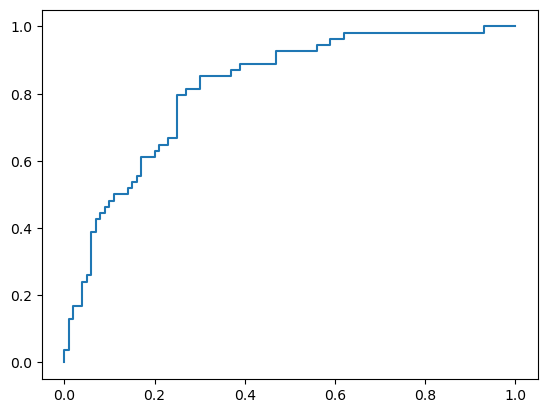

In [166]:
plot_roc(y_test, preds_lgb[1], "LGB baseline")


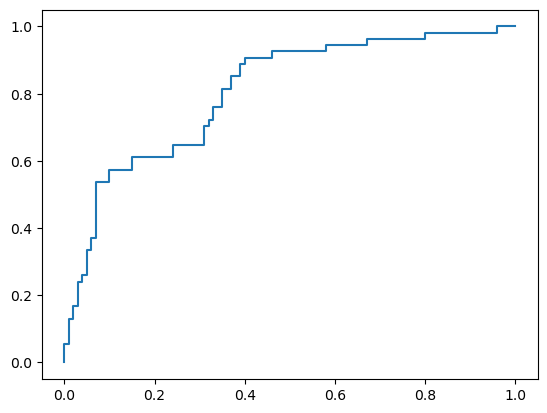

In [167]:
plot_roc(y_test, preds_xgb[1], "XGB baseline")


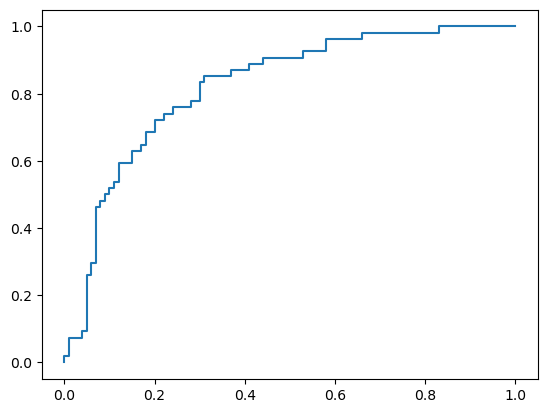

In [168]:
plot_roc(y_test, preds_lgb_tuned[1], "LGB tuned")


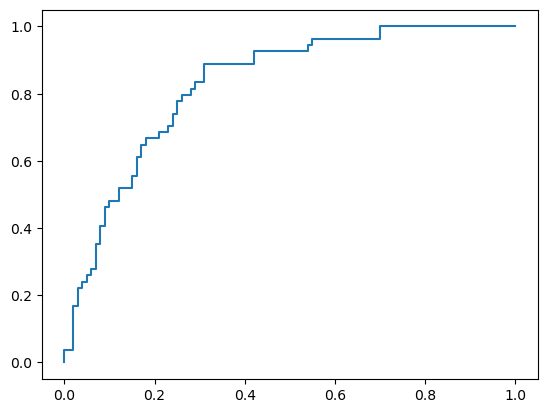

In [169]:
plot_roc(y_test, preds_xgb_tuned[1], "XGB tuned")


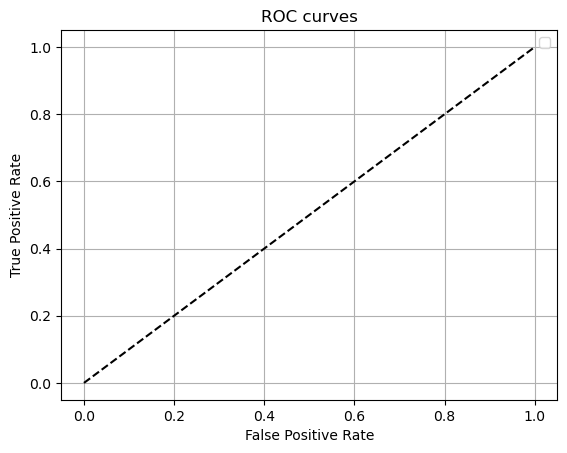

In [170]:
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend()
plt.grid(True)
plt.show()

In [171]:
Submission Requirements:
Well-commented code explaining each step of the analysis.
Visualizations with appropriate titles and labels.
A brief report summarizing the comparative analysis results and practical implications.


SyntaxError: invalid syntax (2043770370.py, line 1)

In [ ]:
try:
    preprocessor.fit(X_train)
    feature_names = numeric_features
    lgb_model = best_lgb.named_steps['clf']
    xgb_model = best_xgb.named_steps['clf']
    lgb_imp = lgb_model.feature_importances_
    xgb_imp = xgb_model.feature_importances_
    fi_df = pd.DataFrame({
        'feature': feature_names,
        'lgb_importance': lgb_imp,
        'xgb_importance': xgb_imp
    }).set_index('feature').sort_values('lgb_importance', ascending=False)
    print("\nTop feature importances (LightGBM):")
    display(fi_df.sort_values('lgb_importance', ascending=False).head(10))
    print("\nTop feature importances (XGBoost):")
    display(fi_df.sort_values('xgb_importance', ascending=False).head(10))

    fi_df['lgb_importance'].sort_values(ascending=False).head(8).plot(kind='bar', figsize=(8,4), title='LightGBM top importances')
    plt.tight_layout(); plt.show()
    fi_df['xgb_importance'].sort_values(ascending=False).head(8).plot(kind='bar', figsize=(8,4), title='XGBoost top importances')
    plt.tight_layout(); plt.show()
except Exception as e:
    print("Could not extract feature importances cleanly:", e)


#### Submission Requirements:
Well-commented code explaining each step of the analysis.
Visualizations with appropriate titles and labels.
A brief report summarizing the comparative analysis results and practical implications.


In [ ]:
report = []
report.append("Diabetes dataset: LightGBM vs XGBoost comparison")
report.append(f"Rows: {df.shape[0]}  Columns: {df.shape[1]}")
report.append("\nComparative metrics (on test set):")
report.append(results.to_string())
report.append("\nBest LGB params: " + str(gs_lgb.best_params_))
report.append("Best XGB params: " + str(gs_xgb.best_params_))
with open("diabetes_lgb_xgb_report.txt","w") as f:
    f.write("\n".join(report))
print("Report saved to diabetes_lgb_xgb_report.txt")